《统计模拟》是 M.ROSS 写的一本小册子，由于这本小册子携带很方便，我通常是在零碎时间看，这样断断续续看了一个学期，导致我学的相当不系统。于是我决定在博客里记录一下书中的内容，帮助自己思路的同时也回顾一下机器学习中的各种 sampling 方法。想想内容其实还是挺多的，所以我初步计划分成三个部分写。这篇博客其中的第一部分，主要内容是(伪)随机数的生成算法，以及对一些简单的分布进行抽样的方法。

## 1. 随机数的生成算法
在介绍具体算法前，先解释一下，我们在各种编程语言中用类似`random()`这样的函数调用得到的随机数大多数是伪随机数，它们通常都是给的一个初始值(称为随机数种子),然后按照一个给定的公式计算下一个值。线性同余发生器是其中最简单的之一，它的计算公式是 \\( X^{n+1} = AX^{n} + B  \mod M \\) 公式中的A,B,M都是事先给定的常数，而\\(X_0\\)就是我们的随机数种子。从这个公式能得到的一个很直观的结论就是这个算法最多产生\\(N (N\leq M)\\)个随机数后就会产生重复的随机数序列,这个就N叫做这个算法的周期。通常我们希望这个算法的周期越长越好，即N越大越好，但是在这个算法里，N要达到\\(M\\)也是不容易的，它对\\(A,B,M\\)的选取有特殊的规定，比如要求\\(B\\)和\\(M\\)互质以及一些其他条件。虽然这个算法简单，但是它的优点很明显，就是计算量小，每生成一个随机数只需要一次乘法一次加法一次取模运算。因此这个算法通常用在一些追求速度的算法中，比如 Word2Vec 中生成随机数就是用的线性同余发生器，它的表达式是 `next_random = next_random*25214903917 +11`,可以看到它的A和B选择了两个很fancy的质数，这里的 next_random C语言中的  long long 型的变量，所以这里的M就隐含着是long long 型变量的最大值。这个算法参数的随机数是否均匀分布可以用下面这段代码来验证，这段代码从这个算法中生成了N个随机数，然后画出了这些随机数归一化后的累积概率分布和概率密度函数。

<!-- TEASER_END -->

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


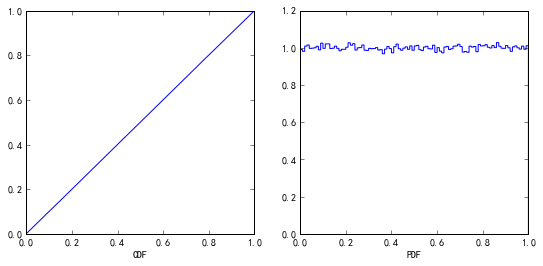

In [12]:
N = 100000
x = zeros(N,dtype=uint64)
x[0] = 1
# 64 位 unsinged int 的最大值
MAX_INT64 = 18446744073709551615

for i in xrange(1,N):
    x[i] = (2514903917*x[i-1] +11)% MAX_INT64

x = x/float(MAX_INT64)
y = arange(0,1,0.001)

figsize(9,4)
subplot(1,2,1)
plot([sum(x<p)/float(N) for p in y], y)
xlabel(u'CDF')
subplot(1,2,2);
hist(x,bins=100,normed=True,histtype='step')
xlabel(u'PDF');

线性同余发生器的问题在于周期不够大，在大量需要随机数的情况下算法会产生重复的随机数序列，geek 们当然不能容忍这样的情况发生，因此现在的编程语言中更通用的算法叫梅森旋转算法，python的random库、c++ 11 STL 都包含这个算法，它的特定是周期特别大，python采用的版本周期是\\(2^{19937}−1\\)，在这么大的周期下，重复序列就不大可能产生了。上面这两个典型的算法都能产生在[0,M-1]上均匀分布的随机数。叫它们伪随机数主要是因为给定一个种子，每次生成的随机数序列都是一样的，这样给定一个足够长的随机数序列，我们总是可以反解出它的各个参数。伪随机数算法的这个特性方便了我们在做一些需要随机性的实验时可以重现实验结果。另一方面，如果在通信中使用这种随机数进行加密，就很容易被别人破解得到种子，进而预测出我们的随机数序列，使得信息被破解。因此在追求安全性的场景下就不能用这种算法。在Linux 下可以采用 /dev/random 来获取随机数,根据 man page 上的描述，这样得到的随机数是密码安全的。

## 2. 简单分布的抽样
有了随机数生成算法，我们只要对所有生成的随机数除以\\(M\\)就可以得到\\([0,1]\\)区间内的均匀分布随机变量(严格来说应该是$[0,1)$不过由于单点集的测度为0,我们给它补上{1}也无妨)。而几乎所有的其他随机变量都可以由均匀随机变量得到。

对简单的随机变量\\(X\\)，它的累积分布函数(*CDF*)是$F(x)$, 定义它的广义逆函数为$$ F^{-1}(y) = \min\nolimits_{k} F_{x}(k)\geq y, y\in[0,1]$$注意对连续型随机变量，广义逆函数就是$F(x)$的逆函数。采用**Inverse Transform Method(ITM)** 进行采样,算法如下:
 1. $从[0,1]上的均匀分布生成样本u$
 2. $y =F^{-1}(u)$
 
算法的证明很简单：

$$\begin{aligned}&\Pr(y\leq x)\\&{}=\Pr(F^{-1}(U)\leq x)\\&{}=\Pr(F(F^{-1}(U))\leq F(x)) \\&{}=\Pr(U\leq F(x))\quad \\&{}=F(x)\quad \end{aligned}$$

上式表明，y 的CDF是$F(x)$,因此y是服从随机变量X分布的样本。用ITM可以对一些简单的随机变量进行抽样，下面我们就来分别对离散的多项分布和连续的指数分布进行抽样。

### 例 1: 多项分布的抽样

In [8]:

def multinomial_sampling(distribution,N=1000):
    """
        distribution: list/ndarray, 分布参数
        N:int, 样本点个数
        return : ndarray, 产生的样本点
    """
    dist = array(distribution)
    # 确保dist的概率值和为1
    assert(abs(sum(dist)-1)<1e-8)
    # 计算累计分布函数
    cum_dist = cumsum(dist)
    # 从均匀分布中抽样N个样本
    x = random.rand(N)
    # 计算使 F(k)>x 的最小 k
    return searchsorted(cum_dist,x)

# 分布参数
dist = [0.2,0.3,0.5]
N = 10000
data=multinomial_sampling(dist,N)

上面这个函数按照ITM算法产生了1000个样本点，我们用下面的代码画出抽样分布的PMF来看看抽样分布的情况。

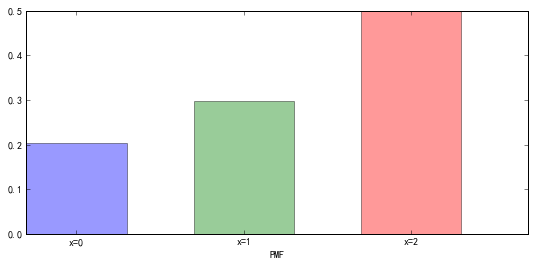

In [11]:
bar_width = 0.3
opacity =0.4
colors = 'bgr'
for i in xrange(3):
    bar(i,sum(data==i)/float(N),bar_width*2,color=colors[i],alpha=opacity)
plt.xticks(arange(len(dist))+bar_width,('x=0','x=1','x=2'));
plt.xlabel(u'PMF');

### 例 2:指数分布的抽样 

指数分布的累积分布函数:$ F(x) = 1-e^{-\lambda x}$,因此: 
$$y = F^{-1}(U)\\{}=-\frac{1}{\lambda}ln(U)$$


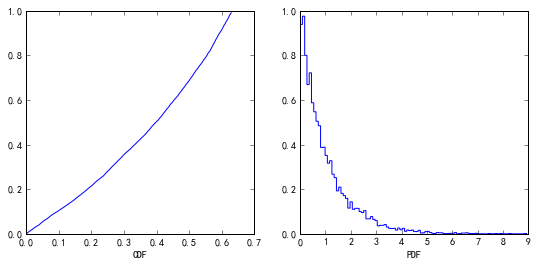

In [17]:
def exponential_sampling(param_lambda,N=10000):
    """
        param_lambda :float, 参数\lambda 
        N: int, 样本点数目
        return : 产生的样本
    """
    assert(param_lambda>0)
    x = random.rand(N)
    return (-1/param_lambda)*log(x)
N = 10000

data = exponential_sampling(5,N)
# 画出 CDF 和 PDF
x = arange(0,1.0,0.01)
subplot(1,2,1)
plot([sum(data<_)/float(N) for _ in x],x)
xlabel('CDF')
subplot(1,2,2)
hist(data,bins=100,normed=True,histtype='step')
xlabel('PDF');

Inverse Transform Method 优点是算法简单，只需要能对待抽样的分布求CDF，不过就算是这么简单的要求有的分布也不一定能满足。比如可以说是概率统计中最重要的分布——高斯分布，由于它的密度函数是典型的不可积函数，就得不到它的累积分布函数。这样对高斯分布抽样就需要我们使用更通用的采样方法。关于这方面的内容留待下篇博客再做介绍。